In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process.kernels import (Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()
from emcee import EnsembleSampler
from emcee.moves import DEMove, DESnookerMove
import corner

/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  dispatcher = jit(_target='npyufunc',


In [98]:
def plot_model_vs_exp_wtrain(q2, ss, model_values, exp_df):
    splots = 2
    fig, ax = plt.subplots(1,splots, figsize = (16, 6))

    Q2_region = (exp_df['Qs2'] == q2) & (exp_df['sqrt(s)'] == ss)
    Q2_indeces = exp_df.index[Q2_region].tolist()
    exp_df_region = exp_df[Q2_region]
    dat = np.array(exp_df_region['sigma_r'])
    dat_err = np.array(exp_df_region['error'])
    xb = np.array(exp_df_region['xbj'])
    

    for i in range(len(model_values)):
        model = [model_values[i,qq2] for qq2 in Q2_indeces]
        ax[0].plot(xb, model, alpha = 0.3, color = 'orange',linewidth = 0.5)
        if i == len(model_values)-1:
            ax[0].plot(xb, model, alpha = 0.9, color = 'orange', linewidth = 0.5, label = "$Q^2 = {}$".format((q2)) +  " GeV$^2$") 
    
    ax[0].plot(np.average(model))
        
    for i in range(len(training_set_all)):
        train = [training_set_all[i,qq2] for qq2 in Q2_indeces]
        ax[1].plot(xb, train, alpha = 0.3, color = 'orange', linewidth = 0.5)
        if i == len(pred_r)-1:
            ax[1].plot(xb, train, alpha = 0.9, color = 'orange', linewidth = 0.5, label = "Training Data")

    for i in range(splots):
        ax[i].errorbar(xb, dat, yerr = dat_err, color = '#0343DF',  fmt = '.', alpha = 0.7, label = "HERA Data")
        #ax[i].set_title("$Q^2$ = {} GeV$^{}$; ".format(q2, 2) + "$\sqrt{s}$ = " + str(ss) + " GeV")
        ax[i].set_xlabel("$x_{bj}$")
        ax[i].set_ylabel("$\sigma_r$ (mb)")
        #ax[0].set_ylim(0.5, 2.0)
        ax[i].set_xscale('log') 
        #ax[i].set_yscale('log')
        ax[i].legend()
        
    return plt.show()
 # make cuts
 # check chi2

def plot_model_vs_exp(q2s, ss, model_values, exp_df):
    colors  = ['orange', 'purple', 'yellow', 'pink', 'red','cyan', 'maroon', 'teal', 'green']
    #colors = sns.color_palette("husl", 8)
    for j in range(len(q2s)):
        q2 = q2s[j]
        Q2_region = (exp_df['Qs2'] == q2) & (exp_df['sqrt(s)'] == ss)
        Q2_indeces = exp_df.index[Q2_region].tolist()
        exp_df_region = exp_df[Q2_region]
        dat = np.array(exp_df_region['sigma_r'])
        dat_err = np.array(exp_df_region['error'])
        xb = np.array(exp_df_region['xbj'])
 
        for i in range(len(model_values)):
            model = [ model_values[i,qq2] for qq2 in Q2_indeces]
            if i == 0:
                plt.plot(xb, model, alpha = 0.8, linewidth = 1.0, color = colors[j], label = "${}$".format((q2)))
            else:
                plt.plot(xb, model, alpha = 0.5, linewidth = 0.3, color = colors[j])
                
        if j == 0:
            plt.errorbar(xb, dat, yerr = dat_err, color = 'black', fmt = '.', label = "Data")        
        else:
            plt.errorbar(xb, dat, yerr = dat_err, color = 'black', fmt = '.')


    plt.xlabel("$x_{bj}$", fontsize = 18)
    plt.ylabel("$\sigma_r$ (mb)", fontsize = 18)
    # set y and x label font sizes
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xscale('log')
    plt.xlim = (10e-6, 10e-1) 
    plt.ylim = (0.4, 1.6)
    #plt.yscale('log')
    # place legend outside of plot
    #plt.legend(title = "$Q^2$ (GeV$^2$)", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title("4-parameter fit", fontsize = 20)
    return plt.show()

In [99]:
def plot_exp_vs_map_vs_median(q2, ss, map_values, exp_df, median_values, median_values_low, median_values_high, confidence = '68%'):
    Q2_region = (exp_df['Qs2'] == q2) & (exp_df['sqrt(s)'] == ss)
    Q2_indeces = exp_df.index[Q2_region].tolist()
    exp_df_region = exp_df[Q2_region]
    dat = np.array(exp_df_region['sigma_r'])
    dat_err = np.array(exp_df_region['error'])
    xb = np.array(exp_df_region['xbj'])

    for i in range(len(map_values)):
        model = [map_values[i,qq2] for qq2 in Q2_indeces]
        plt.plot(xb, model, '--', alpha = 0.8, color = "black", label = "MAP estimates")

    for i in range(len(median_values)):
        model = [median_values[i,qq2] for qq2 in Q2_indeces]
        plt.plot(xb, model, alpha = 0.8, color = "#0343DF", label = " Posterior median")

    for i in range(len(median_values_low)):
        modellow = [median_values_low[i,qq2] for qq2 in Q2_indeces]
        modelhigh = [median_values_high[i,qq2] for qq2 in Q2_indeces]
        plt.fill_between(xb, modellow, modelhigh, alpha = 0.4, label = "{} credible region".format(confidence))
    
    plt.errorbar(xb, dat, yerr = dat_err, color = 'black', fmt = '.', label = "HERA Data")
    plt.title(r"$Q^2 = {} $".format((q2)) + r" GeV$^2$; $\sqrt{s}$" + " = {} GeV".format(ss))   
    plt.xlabel("$x_{bj}$")
    plt.ylabel("$\sigma_r$ (mb)")
    plt.xscale('log') 
    plt.legend()
    return plt.show()


In [2]:
# function to train PCA and GPE, returns trained PCA, GPE, SS

ss = StandardScaler()

def train_PCA_GPE(training_data, theta, primary_components = 2): 

    training_data_scaled = ss.fit_transform(training_data)    
    pca = PCA(n_components = primary_components, whiten = True)
    training_data_PCAd = pca.fit_transform(training_data_scaled)
    gpes = []
    
    for z in training_data_PCAd.T[:primary_components]: # optimize hyper parameters for each pc
        # kernel = 1 * RBF(length_scale = 1 * np.ones(theta.shape[1]), 
        #                  length_scale_bounds = (1e-10, 1e10)) + 1 * WhiteKernel() #+ 1 * ConstantKernel()
        kernel = RBF(length_scale = 1 * np.ones(theta.shape[1]), 
                         length_scale_bounds = (1e-10, 1e10)) + WhiteKernel(noise_level_bounds=(1e-10, 1e1))
        #kernel = RBF() + WhiteKernel() # + ConstantKernel()
        #kernel =  1.0 * Matern(length_scale=1.0, length_scale_bounds = (1e-10, 1e10),nu=1.5)          
        gpe = GaussianProcessRegressor(kernel = kernel,  n_restarts_optimizer = 5) #, normalize_y = True)
        gpes.append(gpe.fit(theta, z))
    
    return gpes, pca, ss

def invert_cov(cov, var_trans, nsamples, nkp):
    return np.dot(np.array(cov).T, var_trans).reshape(nsamples, nkp, nkp) # A.T * cov * A ?

def return_predictions(emulators, theta, return_std_ = True): # fix for return_std = False
    gpes = emulators[0]
    pca = emulators[1]
    ss = emulators[2]
    nsamples = len(theta)
    npc = len(gpes) # number of principal components
    nkp = np.shape(ss.scale_)[0] # number of kinematical points
                   
    mean_prediction = []
    cov_prediction = []
    
    for gpe in gpes: # predicts per principal component: len(gpes) = npc 
        
        mean, cov = gpe.predict(theta, return_cov = return_std_)
        gp_var2 = cov.diagonal()[:, np.newaxis]
        
        mean_prediction.append(mean)
        cov_prediction.append(gp_var2)

    # inverse transform mean prediction
    pred_r = ss.inverse_transform(pca.inverse_transform(np.array(mean_prediction).T))
    
    # make transformation matrix for error
    trans_matrix = pca.components_ * np.sqrt(pca.explained_variance_[:, np.newaxis]) # transformation matrix
    A = trans_matrix[:npc] 
    var_trans = np.einsum('ki,kj->kij', A, A, optimize = False).reshape(npc, nkp**2)
    
    # inverse transform diagonal covariance matrix
    cov_rpca = invert_cov(cov_prediction, var_trans, nsamples, nkp)
    std_preds = np.sqrt(np.diagonal(cov_rpca, axis1 = 1, axis2 = 2)) # standard devs are just
    err_r = ss.scale_ * std_preds
    
    return pred_r, err_r

# log formulas

# log likelihood
def log_likelihood(theta, emulators, data, data_err): # one set of theta only
    theta_reshaped = theta.reshape(1,-1)
    predict, predict_err = return_predictions(emulators, theta_reshaped, return_std_ = True)    
    err2 = (predict_err**2 + (data_err)**2) 
    ll = np.log(2*np.pi*err2) + ((data - predict)**2) / err2 #np.log is natural log 
    return -.5*np.sum(ll)

# some flat prior that sets the bounds of the parameters
def log_flat_prior(theta, l_bounds, u_bounds):
    
    for i in range(np.size(theta)): # check if each parameter is within bounds
        if theta[i] < l_bounds[i] or theta[i] > u_bounds[i]:
            return -np.inf
       
    return 0

# posterior
def log_posterior(theta, l_bounds, u_bounds, emulators, data, data_err):
    return log_likelihood(theta, emulators, data, data_err) + log_flat_prior(theta, l_bounds, u_bounds)

# emcee sampler function
def emcee_sampler(n_walkers, n_params, log_posterior, l_bounds, u_bounds, emulators, data, data_err):
    sampler = EnsembleSampler(n_walkers, 
                              n_params, 
                              log_posterior, 
                              #moves = [(DEMove(), 0.8), (DESnookerMove(), 0.2)],
                              args = [l_bounds, u_bounds, emulators, data, data_err], 
                              threads = 4) # default is stretchmove
    return sampler

def return_samples(p0, l_bounds, u_bounds, n_walkers, n_params, n_samples, n_burn, sampler):
    burn = sampler.run_mcmc(p0, n_burn, progress = True) # initially train until samples converge
    sampler.reset() # remove burn samples
    run = sampler.run_mcmc(burn, n_samples, progress = True)
    return sampler.get_chain(flat = True)

In [3]:
#fig_label = "4p100d232k"

folder = "run2/mve/plainLHS/500d" #"mve/hybrid" #"mve/orthLHS/121d" # w3p20d
train_file, theta_file = [folder + "/train.dat", folder + "/theta.dat"]

folder2 = "mve/plainLHS/150d" #"mve/hybrid" #"mve/orthLHS/121d" # w3p20d
train_file2, theta_file2 = [folder2 + "/train.dat", folder2 + "/theta.dat"]

folder3 = "mve/plainLHS/100d" #"mve/hybrid" #"mve/orthLHS/121d" # w3p20d
train_file3, theta_file3 = [folder3 + "/train.dat", folder3 + "/theta.dat"]

#folder4 = "mve/plainLHS/100d_narrow" #"mve/hybrid" #"mve/orthLHS/121d" # w3p20d
#train_file4, theta_file4 = [folder4 + "/train.dat", folder4 + "/theta.dat"]

exp_file = "exp_all.dat"

param_names = ["$Q_{s0}^{2}$ (GeV²)",
               "$e_c$",
               "$C^{2}$",
               "$\sigma_0/2$ (mb)"] # ordered

# cut training data ()
exp_df = pd.DataFrame(np.loadtxt(exp_file), columns = ['xbj', 'Qs2', 'sqrt(s)', 'sigma_r', 'error'])
a, b = 2.0, 50.0 
# Q2_region = exp_df['Qs2'] < 10.0 # boolean
Q2_region = (exp_df['Qs2'] >= a) & (exp_df['Qs2'] <= b)
Q2_index = exp_df.index[Q2_region].tolist()
exp_df = exp_df[Q2_region]
exp = np.array(exp_df['sigma_r'])
exp_err = np.array(exp_df['error'])

In [4]:
train_dataset1 = pd.DataFrame(np.loadtxt(train_file))
train_dataset2 = pd.DataFrame(np.loadtxt(train_file2))
train_dataset3 = pd.DataFrame(np.loadtxt(train_file3))
#train_dataset = pd.concat([train_dataset1, train_dataset2, train_dataset3], ignore_index=True)
train_dataset = pd.DataFrame(np.loadtxt(train_file))
train_dataset = train_dataset.iloc[:, Q2_index].T.reset_index(drop=True).T
params_1 = np.vstack(np.loadtxt(theta_file, unpack = True)).T
params_2 = np.vstack(np.loadtxt(theta_file2, unpack = True)).T
params_3 = np.vstack(np.loadtxt(theta_file3, unpack = True)).T
#params_all = np.vstack([params_1, params_2, params_3])
params_all = np.vstack(np.loadtxt(theta_file, unpack = True)).T
n_params = len(param_names)
training_set_all = train_dataset.iloc[:,np.array(train_dataset.columns)].values

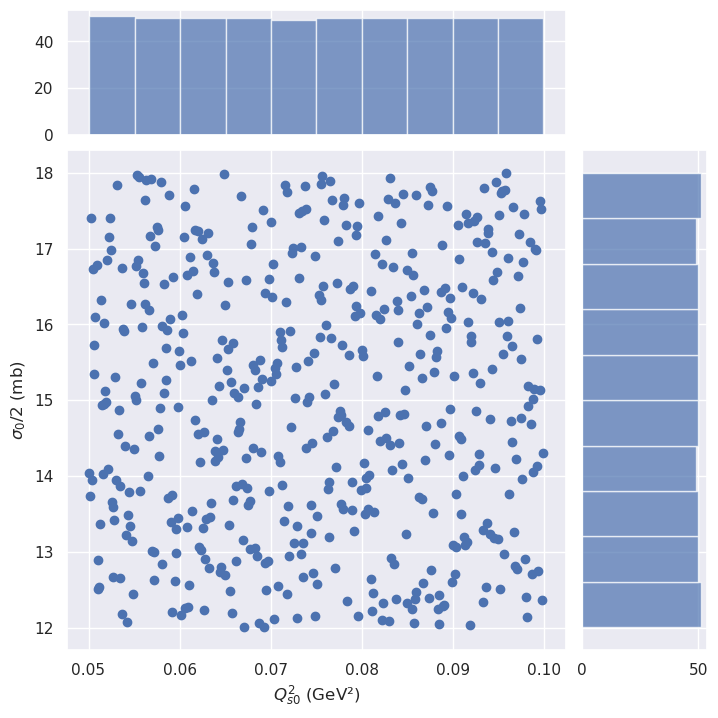

In [5]:
def scatter_hist(a, b, ax, ax_histx, ax_histy):
    # no labels
    x = params_all[:,a]
    y = params_all[:,b]
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)
    ax.set_xlabel(param_names[a])
    ax.set_ylabel(param_names[b])
    ax_histx.hist(x, bins=10, alpha=0.7)
    ax_histy.hist(y, bins=10, orientation='horizontal', alpha=0.7)

# Start with a square Figure.
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Draw the scatter plot and marginals.
scatter_hist(0, 3, ax, ax_histx, ax_histy)

In [6]:
# split to training and test sets

# myparams, myparams_test, training_set, training_set_test = train_test_split(params_all, 
#                                                                             training_set_all, 
#                                                                             test_size = 0.05, 
#                                                                             random_state = 10)


current # of primary components 0
current # of primary components 1
current # of primary components 2
current # of primary components 3
current # of primary components 4
current # of primary components 5
current # of primary components 6
current # of primary components 7
current # of primary components 8
current # of primary components 9


Text(0, 0.5, 'Mean Z score')

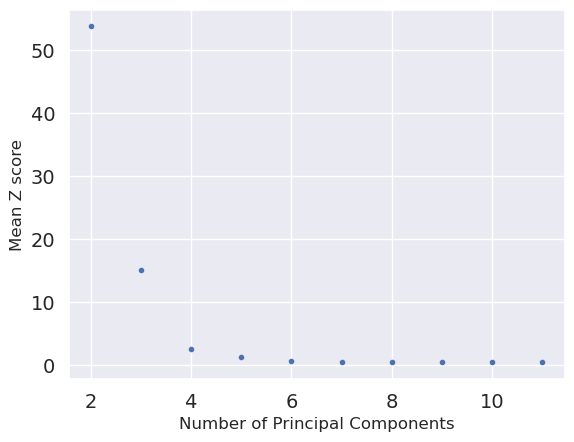

In [100]:
# space for validating() the gpe emulator
z = np.zeros(10)
rd = np.zeros(10)
ems = []
prims = []
for i in range(10):
    prim = i + 2
    prims.append(prim)
    emulators0 = train_PCA_GPE(training_set_all, params_all, primary_components = prim)
    ems.append(emulators0)
    pred_rs, err_rs = return_predictions(ems[i], params_all, return_std_ = True)
    rd_mean = []
    z_mean = []
    for f in range(np.shape(pred_rs)[1]):
        zs = np.mean(np.abs(pred_rs[:,f] - training_set_all[:,f])/err_rs[:,f])
        rds = np.mean(np.abs(pred_rs[:,f] - training_set_all[:,f]))
        z_mean.append(zs)
        rd_mean.append(rds)
    z[i] = np.mean(z_mean)
    rd[i] = np.mean(rd_mean)
    print("current # of primary components", i)

npc = np.where( z == np.amin(z, axis = 0))[0][0] + 2
fig = plt.plot(prims, z, 'b.')
plt.xlabel("Number of Principal Components")
plt.ylabel("Mean Z score")

Text(0, 0.5, 'Mean Relative Difference')

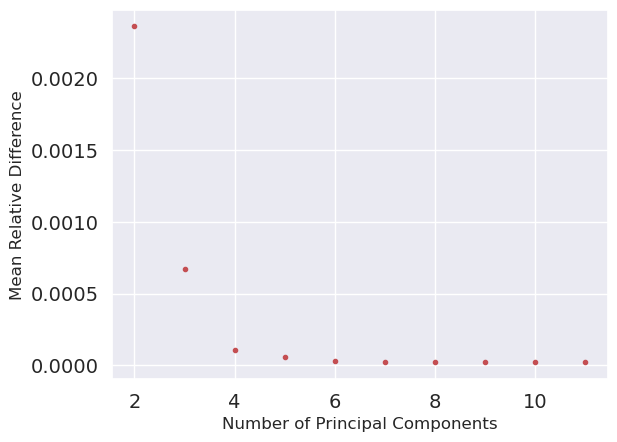

In [101]:
plt.plot(prims, rd, 'r.')
plt.xlabel("Number of Principal Components")
plt.ylabel("Mean Relative Difference")

In [8]:
# train pca, scaler, and gpe
npc = 5
#emulators = train_PCA_GPE(training_set, myparams, primary_components = npc)
emulators = train_PCA_GPE(training_set_all, params_all, primary_components = npc)

# return predictions of fits
pred_r, err_r = return_predictions(emulators, params_all, return_std_ = True)
#pred_r_train, err_r_train = return_predictions(emulators, myparams, return_std_ = True)

0.781 0.04243224103226226


Text(0, 0.5, 'reduced xsec')

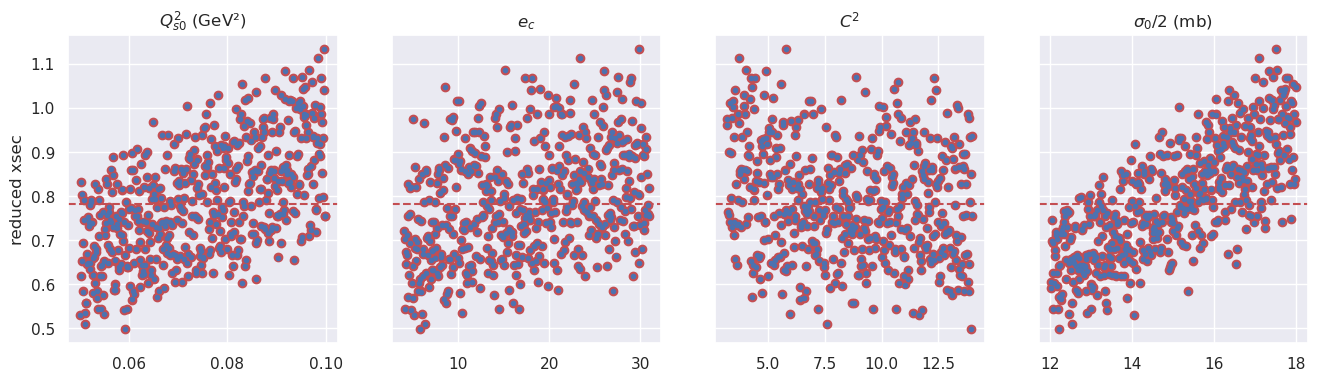

In [9]:
# plot for first kinematical point, comparing training data value and gpe prediction
kp = 0
f, ax = plt.subplots(1, n_params, sharey = True, figsize=(16,4))
for i in range(0,n_params):
    ax[i].errorbar(params_all[:,i], pred_r[:,kp], fmt = '.', yerr = err_r[:,kp], label = "GPE Prediction on Test")
    #ax[i].errorbar(myparams[:,i], pred_r_train[:,kp], fmt = '.', yerr = err_r_train[:,kp], label = "GPE Prediction on Train")
    ax[i].plot(params_all[:,i], training_set_all[:,kp], 'ro', label = 'Test')
    ax[i].axhline(exp[kp],  color = 'r', linestyle = '--', label = 'HERA value')
    ax[i].set_title(param_names[i])
    #ax[i].legend()

# ax[1].set_xscale("log")    
print(exp[kp], exp_err[kp])
ax[0].set_ylabel("reduced xsec")

Text(0, 0.5, 'Training Data $\\sigma_r$')

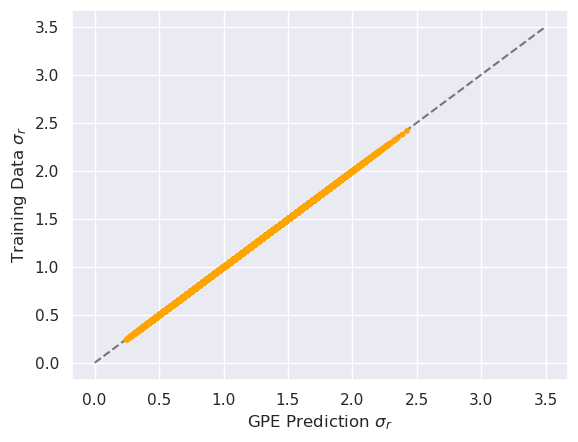

In [10]:
diag = np.linspace(0, 3.5)
plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)

for i in range(400):
    plt.plot(pred_r[:,i], training_set_all[:,i], '.', color = "orange", alpha = 0.5)
    #plt.plot(pred_val[:,i], training_set_val[:,i], '.', color = "orange", alpha = 0.2)

plt.xlabel("GPE Prediction $\sigma_r$")
plt.ylabel("Training Data $\sigma_r$")
#plt.ylim(0.0, 1.0)
#plt.xlim(0.0, 1.0)

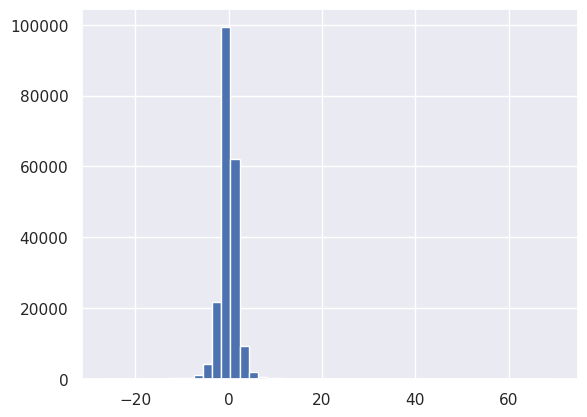

In [11]:
z = np.array([(pred_r[:,kp] - training_set_all[:,kp]) / err_r[:,kp] for kp in range(403)])
plt.hist(z.flatten(), bins = 50);

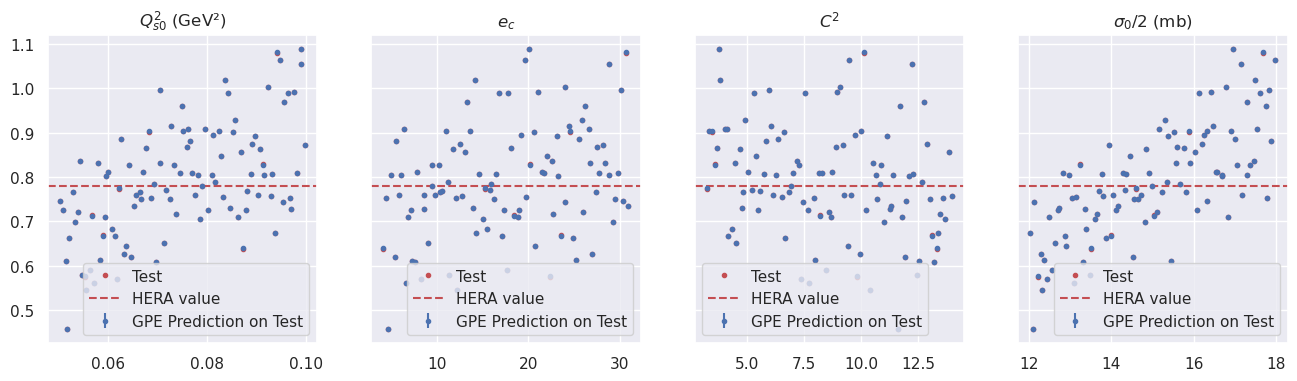

In [12]:
# test agreement on other kinematical points
folder_val = "run2/mve/plainLHS/100d" #"mve/hybrid" #"mve/orthLHS/121d" # w3p20d
train_file_val, theta_file_val = [folder_val + "/train.dat", folder_val + "/theta.dat"]
train_dataset_val = pd.DataFrame(np.loadtxt(train_file_val))
train_dataset_val = train_dataset_val.iloc[:, Q2_index].T.reset_index(drop=True).T
training_set_val = train_dataset_val.iloc[:,np.array(train_dataset_val.columns)].values
myparams_val = np.vstack(np.loadtxt(theta_file_val, unpack = True)).T
pred_val, err_val = return_predictions(emulators, myparams_val, return_std_ = True)
kp = 0
f, ax = plt.subplots(1, n_params, sharey = True, figsize=(16,4))
for i in range(0,n_params):
    ax[i].errorbar(myparams_val[:,i], pred_val[:,kp], fmt = '.', yerr = err_val[:,kp], label = "GPE Prediction on Test")
    #ax[i].errorbar(myparams[:,i], pred_r_train[:,kp], fmt = '.', yerr = err_r_train[:,kp], label = "GPE Prediction on Train")
    ax[i].plot(myparams_val[:,i], training_set_val[:,kp], 'r.', label = 'Test')
    ax[i].axhline(exp[kp],  color = 'r', linestyle = '--', label = 'HERA value')
    ax[i].set_title(param_names[i])
    ax[i].legend()

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6')])

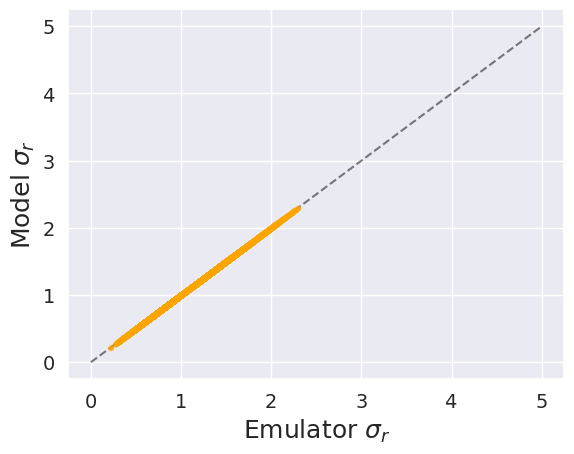

In [13]:
diag = np.linspace(0, 5)
plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)

for i in range(400):
    #plt.plot(pred_r[:,i], training_set_test[:,i], '.', color = "orange", alpha = 0.5)
    plt.plot(pred_val[:,i], training_set_val[:,i], '.', color = "orange", alpha = 0.4)

plt.xlabel("Emulator $\sigma_{r}$", fontsize = 18)
plt.ylabel("Model $\sigma_{r}$", fontsize = 18)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
#plt.ylim(0.0, 0.5)
#plt.xlim(0.0, 0.5)

Text(0.5, 0, 'Model Calculation')

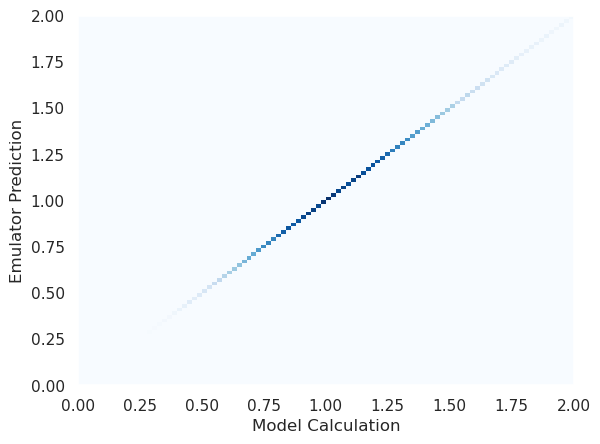

In [14]:
diag = np.linspace(0,2)
#plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)

pred_all = []
training_set_flat_all = []
for i in range(403):
    pred_flat = pred_val[:,i]
    pred_all.append(pred_flat)
    training_set_flat = training_set_val[:,i]
    training_set_flat_all.append(training_set_flat)
    #plt.plot(training_set_flat, pred_flat, '.', color = "orange", alpha = 0.5)
    #plt.hist2d(pred_val[:,i], training_set_val[:,i], '.', color = "orange", alpha = 0.5)

plt.hist2d(np.array(pred_all).flatten(), 
           np.array(training_set_flat_all).flatten(), 
           bins = 100,
           range = [[0, 2.0], [0, 2.0]],
           cmap = "Blues")
plt.ylabel("Emulator Prediction")
plt.xlabel("Model Calculation")
#plt.ylim(0.0, 2.0)
#plt.xlim(0.0, 2.0)

Text(0.5, 0, 'z-score')

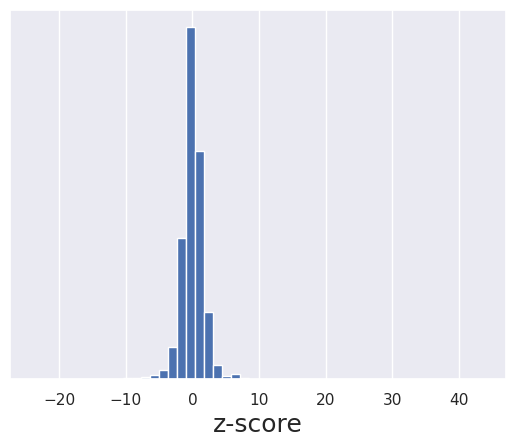

In [16]:
z_val = np.array([(pred_val[:,kp] - training_set_val[:,kp]) / err_val[:,kp] for kp in range(403)])
plt.hist(z_val.flatten(), bins = 50);
#plt.xlim(-2.5,2.5)
# remove x ticks label
plt.yticks([], fontsize = 14)
plt.xlabel("z-score", fontsize = 18)

In [17]:
# are there still negative values in the err_r
for i in range(len(exp)):
    for num in err_r[:,i]:
        if num < 0:
            print(num, end=" ")

In [18]:
from scipy.optimize import minimize, basinhopping
l_bounds = [0.001, 0.5, 0.1, 5.0] # Qs0² , gamma, ec , C², sigma0/2
u_bounds = [0.2, 40.0, 40.0, 30.0] 
initial_guess = np.array([0.06, 18.9, 7.2, 16.36]) # mve from paper

#MAP1 = minimize(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), initial_guess)
MAP1 = minimize(lambda theta: -log_likelihood(theta, emulators, exp, exp_err), initial_guess)
print("Initial Guess for minimize: ", initial_guess)
#print("log likelihood at initial guess:", -log_likelihood(initial_guess, emulators, exp, exp_err))
print("minimize estimates: ", MAP1.x)
print("log likelihod at minimize", MAP1.fun)

map2_kwargs = {"method": "BFGS"}
#MAP2 = basinhopping(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), initial_guess, niter = 200, minimizer_kwargs = map2_kwargs)
MAP2 = basinhopping(lambda theta: -log_likelihood(theta, emulators, exp, exp_err), initial_guess)
print("basinhopping estimates: ", MAP2.x)
print("log likelihood at basinhopping", MAP2.fun)

Initial Guess for minimize:  [ 0.06 18.9   7.2  16.36]
minimize estimates:  [ 0.06487893 23.52004872  4.50205408 14.5946229 ]
log likelihod at minimize -843.103900974919
basinhopping estimates:  [ 0.06278347 28.73233081  4.33309492 14.47535693]
log likelihood at basinhopping -843.1485815647071


In [19]:
print("log likelihood at initial guess:", -log_likelihood(initial_guess, emulators, exp, exp_err))

log likelihood at initial guess: -825.6409758440427


In [68]:
# initializes the walkers in either a small space around the initial guess
# or in a largers space. Well we'll see how it goes
l_bounds = [0.001, 0.5, 0.1, 5.0] # Qs0² , ec , C², sigma0/2
u_bounds = [0.2, 40.0, 40.0, 30.0] 

# MLE (minimize) for 500d: minimize estimates:  
l_bounds_in = [0.06, 23.0, 4.0, 15.0]
u_bounds_in = [0.07, 29.0, 5.0, 17.0]

mylimits = np.array([l_bounds, u_bounds])
n_walkers = 100 #100
n_burn = 1000
n_samples = 1000

p0 = np.random.uniform(l_bounds_in, u_bounds_in, size = (n_walkers,n_params))
sampler1 = emcee_sampler(n_walkers, n_params, log_posterior, l_bounds, u_bounds, emulators, exp, exp_err)
paramsamples = return_samples(p0,l_bounds, u_bounds, n_walkers, n_params, n_samples, n_burn, sampler1)
 
for i in range(n_params): # print means
    print(param_names[i] + "= {0:.3f}".format(np.mean(paramsamples[:,i])))

print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler1.acceptance_fraction)))

100%|██████████| 1000/1000 [14:31<00:00,  1.15it/s]

$Q_{s0}^{2}$ (GeV²)= 0.065
$e_c$= 23.480
$C^{2}$= 4.668
$\sigma_0/2$ (mb)= 14.678
Mean acceptance fraction: 0.330


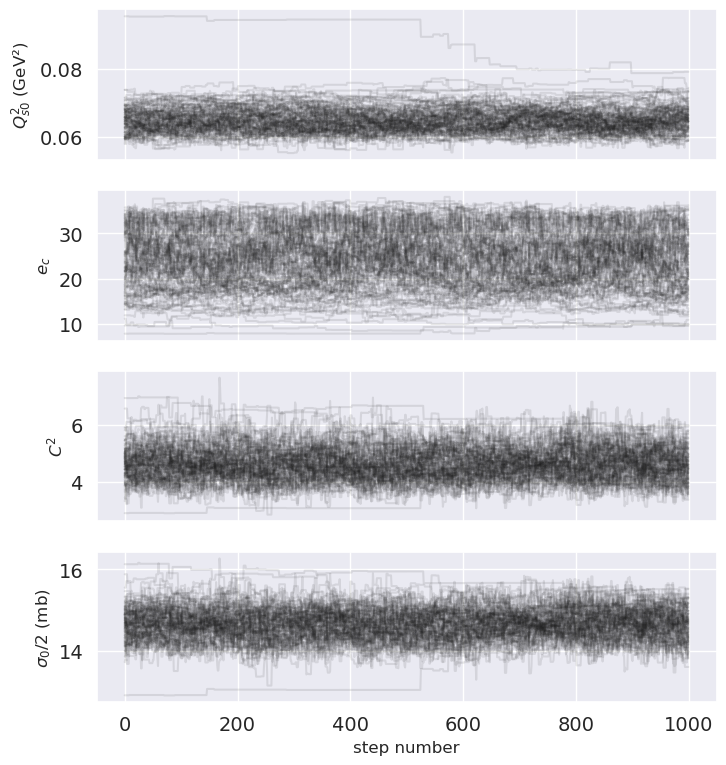

In [69]:
fig, axes = plt.subplots(n_params, 1, sharex = True, figsize = (8, 9))
for i in range(n_params):
    axes[i].plot(sampler1.chain[:,:,i].T, color = 'k', alpha = 0.1)
    axes[i].set_ylabel(param_names[i])
    axes[-1].set_xlabel('step number')

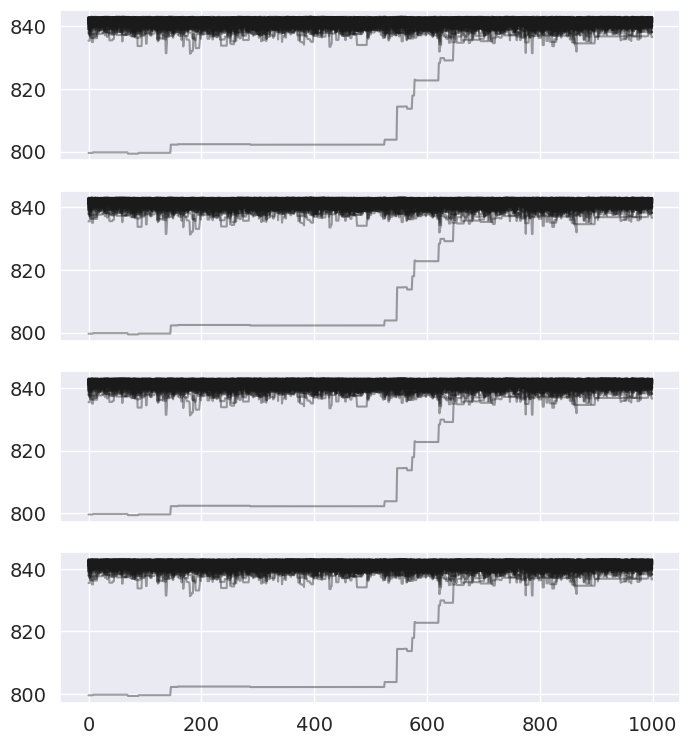

In [70]:
fig, axes = plt.subplots(n_params, 1, sharex = True, figsize = (8, 9))
for i in range(n_params):
    axes[i].plot(sampler1.get_log_prob(), color = 'k', alpha = 0.4)
    #axes[i].set_ylabel('log probability')
    #axes[-1].set_xlabel('step number')
    #axes[i].set_ylim(0, 800)

In [71]:
# unpack all samples that are saved in txt file
# paramsamples = np.vstack(np.loadtxt("mve/plainLHS/mve_100d_100w_allsamples.txt", unpack = True)).T

Quantiles:
[(0.05, 0.05960820460135926), (0.5, 0.06479861987799522), (0.95, 0.07220517207537798)]
Quantiles:
[(0.05, 12.740632340178387), (0.5, 23.40700562779011), (0.95, 34.58586277936601)]
Quantiles:
[(0.05, 3.790998068122603), (0.5, 4.62161623489804), (0.95, 5.708477229183345)]
Quantiles:
[(0.05, 14.060987986487012), (0.5, 14.677974737463582), (0.95, 15.333160504155554)]


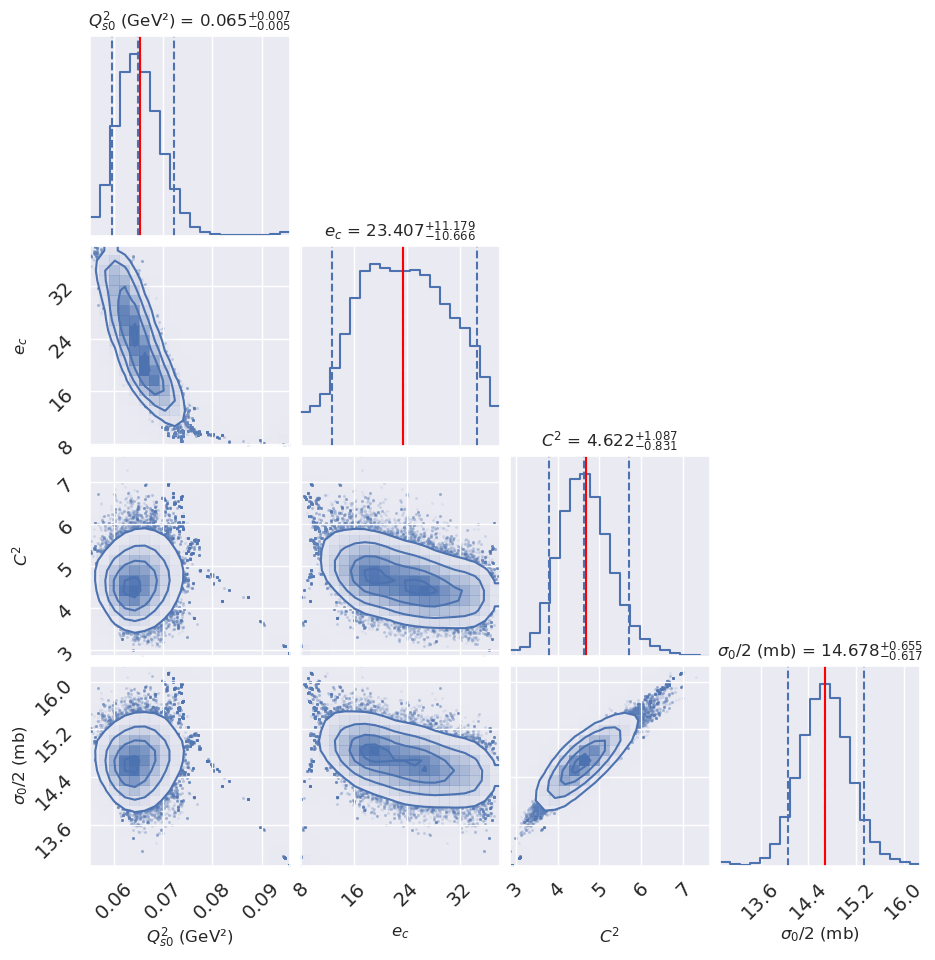

In [72]:
figure = corner.corner(
    paramsamples,
    labels = param_names,
    plot_contours = True,
    quantiles=[0.05, 0.5, 0.95],
    show_titles = True, # 
    title_fmt = '.3f',
    title_kwargs={"fontsize": 12}, 
    color = 'b',
    #bins = 50,
    smooth1d = True,
    smooth = True,
    verbose = True,
    #plot_density = True,
    #reverse= True,
    fillcontours = True, # 
    hist2d_kwargs = {"plot_density": True} # conto
)

ndim = n_params
axes = np.array(figure.axes).reshape((ndim, ndim))

import math
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(np.mean(paramsamples[:,i]), color="red")


# Loop over the histograms
#for yi in range(ndim):
#    for xi in range(yi):
#        ax = axes[yi, xi]
#        ax.axvline(np.mean(paramsamples[:,xi]), color="r")
#        ax.axhline(np.mean(paramsamples[:,yi]), color="r")
#        ax.plot(np.mean(paramsamples[:,xi]), np.mean(paramsamples[:,yi]), "sr")

In [73]:
# how to sample from the posterior
inds = np.random.randint(len(paramsamples), size=100)
post_samples = [paramsamples[i] for i in inds]
#np.savetxt("mve/plainLHS/mve_500d_run2_100w_sampled_from_posterior_100.txt", np.array(post_samples), delimiter = " ", newline = "\n")
#np.savetxt("mve/plainLHS/mve_500d_run2_100w_allsamples.txt", np.array(paramsamples), delimiter = " ", newline = "\n")

In [3]:
# import numpy as np
# i = 0
# lines = ['#!/bin/bash', '\n']
# post_samples = np.vstack(np.loadtxt("mve/plainLHS/mve_500d_run2_100w_sampled_from_posterior_100.txt", unpack = True)).T
# #print(myparams)
# for qs02, gamma, ec, c2 in post_samples[:, 0:4]:
#     line = "sbatch -J bk submitmv5.sh {0} {1} {2} {3} {4}".format(str(qs02), str(gamma) ,str(ec), str(c2),str(i))
#     lines.append(line)
#     i += 1
# np.savetxt('postsamples_mve_100d_trainedon500d.sh', lines, newline = '\n', fmt='%s')

In [86]:
from scipy.optimize import minimize
#paramsamples = np.vstack(np.loadtxt("mve/plainLHS/mve_all500d_100w_allsamples.txt", unpack = True)).T
#post_samples = np.vstack(np.loadtxt("mve/plainLHS/mve_all500d_100w_sampled_from_posterior_100.txt", unpack = True)).T
model_values, model_values_err = return_predictions(emulators, post_samples, return_std_ = True)
posterior_median = np.median(paramsamples, axis = 0) # median values of the posterior as initial guess; code still works for other guesses, it just takes longer to run
l_bounds = [0.001, 0.5, 0.1, 5.0] # Qs0² , gamma, ec , C², sigma0/2
u_bounds = [0.2, 40.0, 40.0, 30.0]
MAP = minimize(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), posterior_median)
MAPx = MAP.x
MAPT = MAPx.reshape(1,-1)
MAPT_values, MAPT_values_err = return_predictions(emulators, MAPT, return_std_ = True)
median_values, median_values_err = return_predictions(emulators, np.array(posterior_median).reshape(1,-1), return_std_ = True)

/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


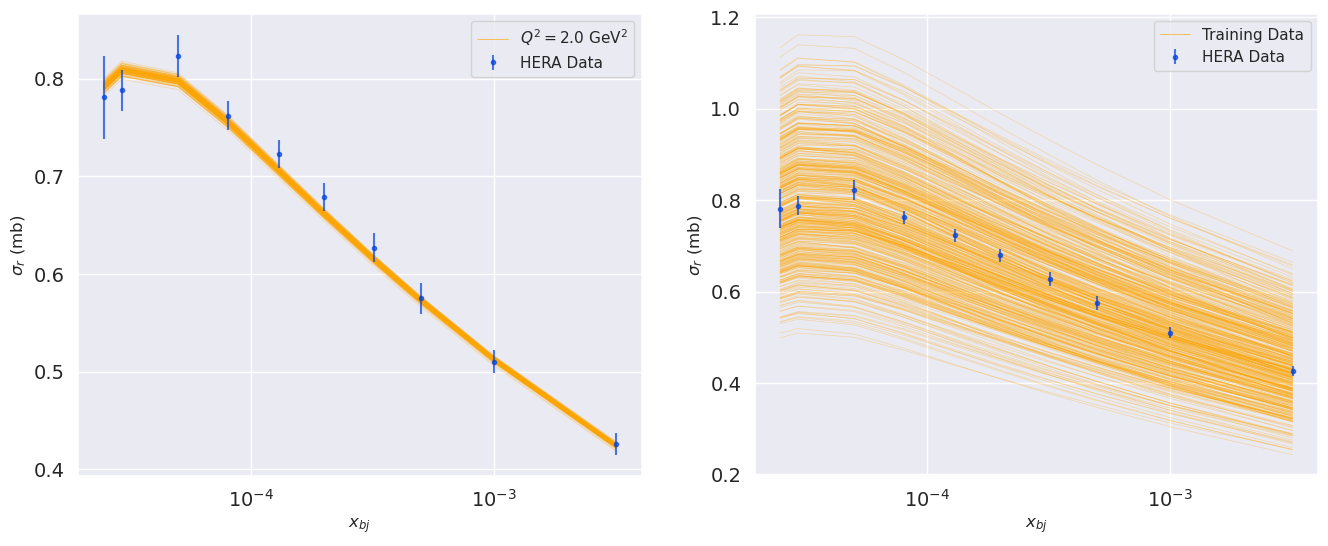

In [90]:
plot_model_vs_exp_wtrain(2., 318.0, model_values, exp_df)

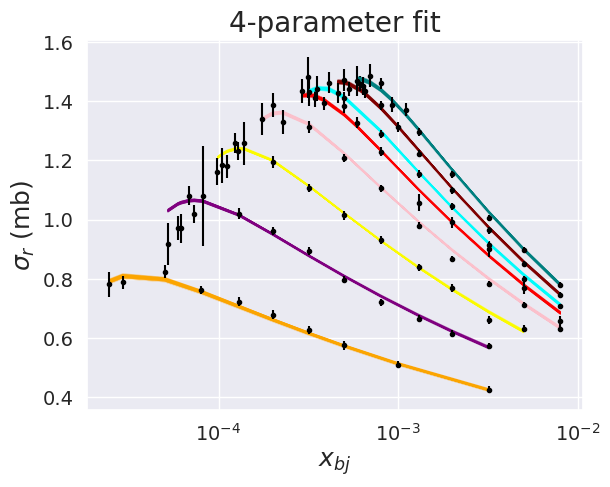

In [91]:
plot_model_vs_exp([2., 4.5, 8.5, 15.0, 22.0,  27.,  35.,  45.], 318.0, model_values, exp_df)
# make for each Q2?

In [92]:
# getting MAP values

from scipy.optimize import minimize
posterior_median = np.median(paramsamples, axis = 0) # median values of the posterior as initial guess; code still works for other guesses, it just takes longer to run
MAP = minimize(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), posterior_median)
percentile_16 = np.percentile(paramsamples, 16, axis = 0)
percentile_84 = np.percentile(paramsamples, 84, axis = 0)
percentile_5 = np.percentile(paramsamples, 5, axis = 0)
percentile_95 = np.percentile(paramsamples, 95, axis = 0)

print("MAP estimates: ", MAP.x)
print("log posterior at MAP: ", MAP.fun)
print("Median Values: ", posterior_median)
print("log posterior at Median: ", -log_posterior(posterior_median, l_bounds, u_bounds, emulators, exp, exp_err))
print("16th percentile: ", percentile_16)
print("84th percentile: ", percentile_84)
print("5th percentile: ", percentile_5)
print("95th percentile: ", percentile_95)

/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/carlisle/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


MAP estimates:  [ 0.06289234 28.48313763  4.33411297 14.47591241]
log posterior at MAP:  -843.148472083019
Median Values:  [ 0.06479862 23.40700563  4.62161623 14.67797474]
log posterior at Median:  -839.9729651060777
16th percentile:  [ 0.06139621 16.41053162  4.1092022  14.30029947]
84th percentile:  [ 0.0691368  31.1189299   5.22848608 15.05020395]
5th percentile:  [ 0.0596082  12.74063234  3.79099807 14.06098799]
95th percentile:  [ 0.07220517 34.58586278  5.70847723 15.3331605 ]


In [93]:
MAPT = MAP.x.reshape(1,-1)
MAPT_values, MAPT_values_err = return_predictions(emulators, MAPT, return_std_ = True)
median_values, median_values_err = return_predictions(emulators, np.array(posterior_median).reshape(1,-1), return_std_ = True)
median_values_5, median_values_err_5 = return_predictions(emulators, np.array(percentile_5).reshape(1,-1), return_std_ = True)
median_values_95, median_values_err_95 = return_predictions(emulators, np.array(percentile_95).reshape(1,-1), return_std_ = True)
median_values_16, median_values_err_16 = return_predictions(emulators, np.array(percentile_16).reshape(1,-1), return_std_ = True)
median_values_84, median_values_err_84 = return_predictions(emulators, np.array(percentile_84).reshape(1,-1), return_std_ = True)

In [94]:
#plot_exp_vs_map_vs_median(45.0, 318.0, MAPT_values, exp_df, median_values, median_values_16, median_values_84)

In [95]:
thetas = np.vstack(np.loadtxt("candidates_mve.dat", unpack = True)).T
lps = [log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err) for theta in thetas]
print(np.array(lps).T)

[ 1.52487864e+02  2.45255107e+02 -5.64031418e+04 -7.22406902e+01
 -3.20878703e+03 -3.78499058e+03 -3.25424412e+03 -3.07233830e+03
 -2.07316447e+05 -1.78130267e+04 -9.64204162e+03 -1.32175095e+04
 -1.77122866e+04  8.25640976e+02 -1.86420426e+04 -7.74625698e+02
 -8.05103716e+02 -2.13401952e+04  7.90127401e+02]


In [96]:
def my_chi2(data, exp, exp_err):
    return np.sum(((data - exp)**2)/exp_err**2)/403